In [1]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')


# 1.1 -Basics of geological modeling with GemPy


Importing GemPy



In [2]:
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Setting options
np.random.seed(1515)
pd.set_option('display.precision', 2)

## Importing and creating a set of input data
The data used for the construction of a model in GemPy is stored in
Python objects. The main data classes are:

::

    -  Surface_points
    -  Orientations
    -  Grid
    -  Surfaces
    -  Series
    -  Additional data
    -  Faults

We will see each of this class in further detail in the future.

Most of data can also be generated from raw data that comes in the form
of CSV-files (CSV = comma-separated values). Such files might be
attained by exporting model data from a different program such as
GeoModeller or by simply creating it in spreadsheet software such as
Microsoft Excel or LibreOffice Calc.

In this tutorial, all input data is created by importing such CSV-files.
These exemplary files can be found in the ``input_data`` folder in the
root folder of GemPy. The data comprises $x$-, $y$- and
$z$-positional values for all surface points and orientation
measurements. For the latter, poles, azimuth and polarity are
additionally included. Surface points are furthermore assigned a
formation. This might be a lithological unit such as "Sandstone" or a
structural feature such as "Main Fault". It is decisive to remember
that, in GemPy, interface position points mark the **bottom** of a
layer. If such points are needed to resemble a top of a formation (e.g.
when modeling an intrusion), this can be achieved by defining a
respectively inverted orientation measurement.

As we generate our ``Data`` from CSV-files, we also have to define our
model's real extent in $x$, $y$ and $z$, as well as
declare a desired resolution for each axis. This resolution will in turn
determine the number of voxels used during modeling. Here, we rely on a
medium resolution of 50x50x50, amounting to 125,000 voxels. The model
extent should be chosen in a way that it contains all relevant data in a
representative space. As our model voxels are not cubes, but prisms, the
resolution can take a different shape than the extent. We don't
recommend going much higher than 100 cells in every direction (1,000,000
voxels), as higher resolutions will become increasingly expensive to
compute.




In [3]:
geo_model = gp.create_model('Brothers_demo')

In [4]:
data_path = 'https://raw.githubusercontent.com/FisPrObXu/Brothers_Volc_NJUCYF/main/'
# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0, 2000., 0, 3000., 0, 2500.], [50, 50, 50],
             path_o=data_path + "/data_file/"
                                "brothers_cross-section_orientations_rotated_demo.csv",
             path_i=data_path + "/data_file/"
                                "reduced_brothers_cross-section_points_rotated.csv",
             default_values=True)

Active grids: ['regular']


Brothers_demo  2024-04-10 17:22

In [5]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Sandstone_2,Default series,1,#015482,1
1,Siltstone,Default series,2,#9f0052,2
2,Sandstone_1,Default series,3,#ffbe00,3
3,Shale,Default series,4,#728f02,4
4,Main_Fault,Default series,5,#443988,5
5,basement,Basement,1,#ff3f20,6


The input data can then be listed using the command ``get_data``. Note
that the order of formations and respective allocation to series is
still completely arbitrary. We will fix this in the following.




In [6]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,smooth,surface
0,1414.21,1967.60,1290.68,2.00e-06,Sandstone_2
1,1414.21,1229.75,1282.36,2.00e-06,Sandstone_2
2,1414.21,983.80,1320.63,2.00e-06,Sandstone_2
3,1414.21,1844.63,1461.23,2.00e-06,Sandstone_2
4,1414.21,1721.65,1437.10,2.00e-06,Sandstone_2


In [7]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,1000,1414.21,700,0.32,1.00e-12,0.95,0.01,Sandstone_1
1,400,1414.21,320,0.32,1.00e-12,0.95,0.01,Shale
2,500,1414.21,600,-0.95,1.00e-12,0.32,0.01,Main_Fault


### Declaring the sequential order of geological formations

-  TODO update this section

We want our geological units to appear in the correct order relative to
age. Such order might for example be given by a depositional sequence of
stratigraphy, unconformities due to erosion or other lithological
genesis events such as igneous intrusions. A similar age-related order
is to be declared for the faults in our model. In GemPy, the function
``set_series`` is used to assign formations to different sequential
series via declaration in a Python dictionary.

Defining the correct order of series is vital to the construction of the
model! If you are using Python >3.6, the age-related order will already
be defined by the order of key entries, i.e. the first entry is the
youngest series, the last one the oldest. For older versions of Python,
you will have to specify the correct order as a separate list attribute
"``order_series``\ " (see cell below).

You can assign several surfaces to one series. The order of the units
within such as series is only relevant for the color code, thus we
recommend to be consistent. You can define this order via another
attribute "``order_formations``/ " or by using the specific command
``set_order_formations``. (If the order of the pile differs from the
final result the color of the interfaces and input data will be
different.)

Every fault is treated as an independent series and have to be at set at
the **top of the pile**. The relative order between the distinct faults
defines the tectonic relation between them (first entry is the
youngest).

In a model with simple sequential stratigraphy, all layer formations can
be assigned to one single series without a problem. All unit boundaries
and their order would then be given by interface points. However, to
model more complex lithostratigraphical relations and interactions, the
definition of separate series becomes important. For example, you would
need to declare a "newer" series to model an unconformity or an
intrusion that disturbs older stratigraphy.

By default we create a simple sequence inferred by the data:




Our example model comprises four main layers (plus an underlying
basement that is automatically generated by GemPy) and one main normal
fault displacing those layers. Assuming a simple stratigraphy where each
younger unit was deposited onto the underlying older one, we can assign
these layer formations to one series called "Strat\_Series". For the
fault, we declare a respective "Fault\_Series" as the first key entry in
the ``set_series`` dictionary. We could give any other names to these
series, the formations however have to be referred to as named in the
input data.




In [8]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Sandstone_2,Default series,1,#015482,1
1,Siltstone,Default series,2,#9f0052,2
2,Sandstone_1,Default series,3,#ffbe00,3
3,Shale,Default series,4,#728f02,4
4,Main_Fault,Default series,5,#443988,5
5,basement,Basement,1,#ff3f20,6


In [9]:
gp.map_stack_to_surfaces(geo_model,
                         {"Fault_Series": 'Main_Fault',
                          "Strat_Series": ('Sandstone_2', 'Siltstone',
                                           'Shale', 'Sandstone_1', 'basement')},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
4,Main_Fault,Fault_Series,1,#443988,1
0,Sandstone_2,Strat_Series,1,#015482,2
1,Siltstone,Strat_Series,2,#9f0052,3
2,Sandstone_1,Strat_Series,3,#ffbe00,4
3,Shale,Strat_Series,4,#728f02,5
5,basement,Strat_Series,5,#ff3f20,6


In [10]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
4,Main_Fault,Fault_Series,1,#443988,1
0,Sandstone_2,Strat_Series,1,#015482,2
1,Siltstone,Strat_Series,2,#9f0052,3
2,Sandstone_1,Strat_Series,3,#ffbe00,4
3,Shale,Strat_Series,4,#728f02,5
5,basement,Strat_Series,5,#ff3f20,6


In [11]:
geo_model.stack

,order_series,BottomRelation,isActive,isFault,isFinite
Fault_Series,1,Erosion,True,False,False
Strat_Series,2,Erosion,True,False,False


In [12]:
geo_model.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault_Series,1,Fault,True,True,False
Strat_Series,2,Erosion,True,False,False


In [13]:
geo_model.faults.faults_relations_df

,Fault_Series,Strat_Series
Fault_Series,False,True
Strat_Series,False,False


In [14]:
geo_model.faults

,order_series,BottomRelation,isActive,isFault,isFinite
Fault_Series,1,Fault,True,True,False
Strat_Series,2,Erosion,True,False,False


In [15]:
geo_model.faults.faults_relations_df

,Fault_Series,Strat_Series
Fault_Series,False,True
Strat_Series,False,False


### Returning information from our input data

Our model input data, here named "*geo\_model*", contains all the
information that is essential for the construction of our model. You can
access different types of information by using ``gp.get_data`` or simply
by accessiong the atrribues.

We can, for example, return the coordinates of our modeling grid via:




In [16]:
geo_model.grid

Grid Object. Values: 
array([[  20.,   30.,   25.],
       [  20.,   30.,   75.],
       [  20.,   30.,  125.],
       ...,
       [1980., 2970., 2375.],
       [1980., 2970., 2425.],
       [1980., 2970., 2475.]])

As mentioned before, GemPy's core algorithm is based on interpolation of
two types of data: - surface\_points and - orientation measurements

(if you want to know more on how this this interpolation algorithm
works, checkout our paper: https://www.geosci-model-dev.net/12/1/2019/gmd-12-1-2019.pdf).

We introduced the function ``get\_data`` above. You can also specify which
kind of data you want to call, by declaring the string attribute
"*dtype*" to be either ``'surface_points'`` (interfaces) or ``'orientations'``\ .

### Interfaces Dataframe:




In [17]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,smooth,surface
76,700.0,1414.21,1450.0,2.00e-06,Main_Fault
77,700.0,1414.21,1350.0,2.00e-06,Main_Fault
78,700.0,1414.21,1250.0,2.00e-06,Main_Fault
79,700.0,1414.21,1150.0,2.00e-06,Main_Fault
80,700.0,1414.21,1050.0,2.00e-06,Main_Fault


### Orientations Dataframe:




In [18]:
gp.get_data(geo_model, 'orientations')

,X,Y,Z,G_x,G_y,G_z,smooth,surface
2,500,1414.21,600,-0.95,1.00e-12,0.32,0.01,Main_Fault
0,1000,1414.21,700,0.32,1.00e-12,0.95,0.01,Sandstone_1
1,400,1414.21,320,0.32,1.00e-12,0.95,0.01,Shale


Notice that now all **surfaces** have been assigned to a **series** and
are displayed in the correct order (from young to old).

### Visualizing input data

We can also visualize our input data. This might for example be useful
to check if all points and measurements are defined the way we want them
to. Using the function ``plot_data``\ , we attain a 2D projection of our
data points onto a plane of chosen *direction* (we can choose this
attribute to be either $x$, $y$ or $z$).




d:\anaconda3\envs\gempy-env\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


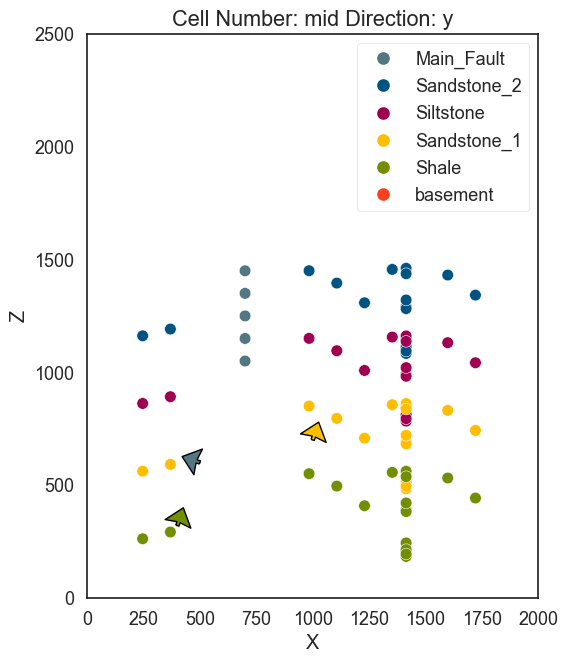

In [19]:
plot = gp.plot_2d(geo_model, show_lith=False, show_boundaries=False)
plt.show()

Using ``plot_data_3D``\ , we can also visualize this data in 3D. Note that
direct 3D visualization in GemPy requires `the Visualization
Toolkit <https://www.vtk.org/>`__ (VTK) to be installed.

All 3D plots in GemPy are interactive. This means that we can drag
and drop any data point and measurement. The perpendicular axis views in
VTK are particularly useful to move points solely on a desired 2D plane.
Any changes will then be stored permanently in the "InputData"
dataframe. If we want to reset our data points, we will then need to
reload our original input data.

Executing the cell below will open a new window with a 3D interactive
plot of our data.



In [20]:
gpv = gp.plot_3d(geo_model, image=False, plotter_type='basic')

### Model generation

Once we have made sure that we have defined all our primary information
as desired in our object ``DataManagement.InputData`` (named
``geo_data`` in these tutorials), we can continue with the next step
towards creating our geological model: preparing the input data for
interpolation.

This is done by generating an ``InterpolatorData`` object (named
``interp_data`` in these tutorials) from our ``InputData`` object via
the following function:




In [21]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    )

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                     values
range              4387.48
$C_o$            458333.33
drift equations     [3, 3]


This function rescales the extent and coordinates of the original data
(and store it in the attribute ``geo_data_res`` which behaves as a usual
``InputData`` object) and adds mathematical parameters that are needed
for conducting the interpolation. The computation of this step may take
a while, as it also compiles a theano function which is required for the
model computation. However, should this not be needed, we can skip it by
declaring ``compile_theano = False`` in the function.

Furthermore, this preparation process includes an assignment of numbers
to each formation. Note that GemPy's always creates a default basement
formation as the last formation number. Afterwards, numbers are
allocated from youngest to oldest as defined by the sequence of series
and formations. On the property ``formations`` on our interpolation
data, we can find out which number has been assigned to which formation:




The parameters used for the interpolation can be returned using the
function ``get_kriging_parameters``. These are generated automatically
from the original data, but can be changed if needed. However, users
should be careful doing so, if they do not fully understand their
significance.




In [22]:
gp.get_data(geo_model, 'kriging')

,values
range,4387.48
$C_o$,458333.33
drift equations,"[3, 3]"


At this point, we have all we need to compute our full model via
``compute_model``. By default, this will return two separate solutions
in the form of arrays. The first gives information on the lithological
formations, the second on the fault network in the model. These arrays
consist of two subarrays as entries each:

1. Lithology block model solution:

   -  Entry [0]: This array shows what kind of lithological formation is
      found in each voxel, as indicated by a respective
      formation\_number.
   -  Entry [1]: Potential field array that represents the orientation
      of lithological units and layers in the block model.

2. Fault network block model solution:

   -  Entry [0]: Array in which all fault-separated areas of the model
      are represented by a distinct number contained in each voxel.
   -  Entry [1]: Potential field array related to the fault network in
      the block model.

Below, we illustrate these different model solutions and how they can be
used.




In [23]:
sol = gp.compute_model(geo_model)

In [24]:
sol


Lithology ids 
  [6. 6. 6. ... 2. 2. 2.] 

In [25]:
geo_model.solutions


Lithology ids 
  [6. 6. 6. ... 2. 2. 2.] 

### Direct model visualization in GemPy

Model solutions can be easily visualized in 2D sections in GemPy
directly. Let's take a look at our lithology block:




d:\anaconda3\envs\gempy-env\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


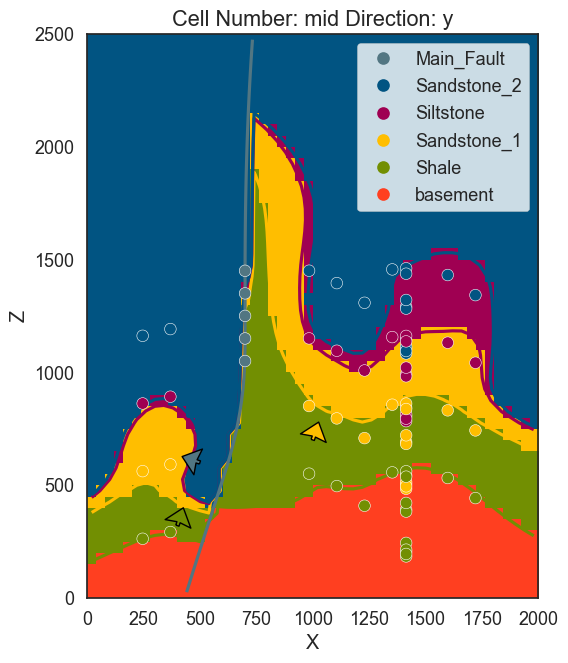

In [26]:
gp.plot_2d(geo_model, show_data=True)
plt.show()

With ``cell_number=25`` and remembering that we defined our resolution
to be 50 cells in each direction, we have chosen a section going through
the middle of our block. We have moved 25 cells in ``direction='y'``,
the plot thus depicts a plane parallel to the $x$- and
$y$-axes. Setting ``plot_data=True``, we could plot original data
together with the results. Changing the values for ``cell_number`` and
``direction``, we can move through our 3D block model and explore it by
looking at different 2D planes.

We can do the same with out lithological scalar-field solution:




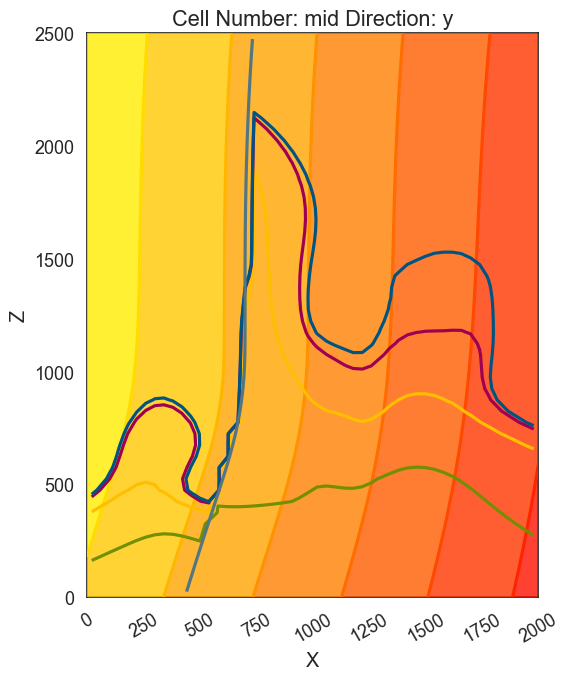

In [27]:
gp.plot_2d(geo_model, show_data=False, show_scalar=True, show_lith=False)
plt.show()

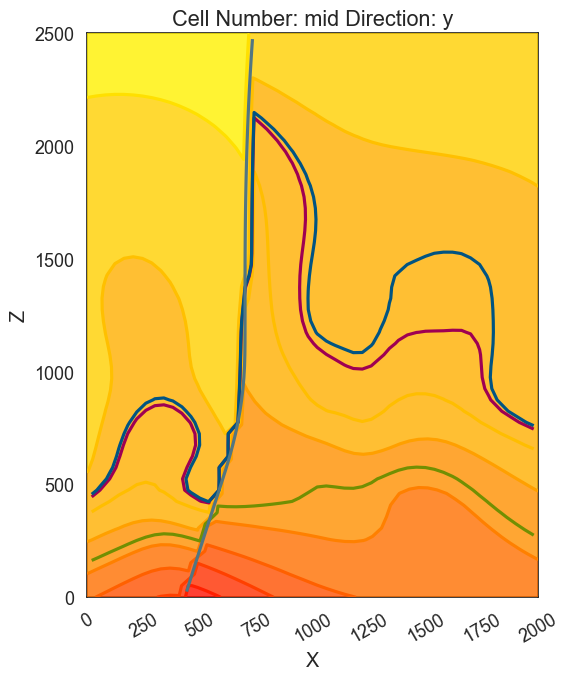

In [28]:
gp.plot_2d(geo_model, series_n=1, show_data=False, show_scalar=True, show_lith=False)
plt.show()

This illustrates well the fold-related deformation of the stratigraphy,
as well as the way the layers are influenced by the fault.

The fault network modeling solutions can be visualized in the same way:




In [29]:
geo_model.solutions.scalar_field_at_surface_points

array([[-0.63435058,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.14529085,  0.14455498,  0.13922687,  0.10708423]])

d:\anaconda3\envs\gempy-env\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


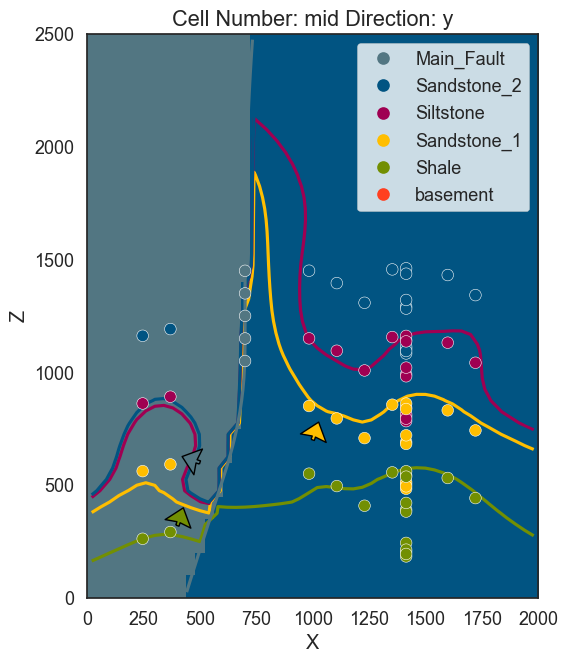

In [30]:
gp.plot_2d(geo_model, show_block=True, show_lith=False)
plt.show()

d:\anaconda3\envs\gempy-env\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


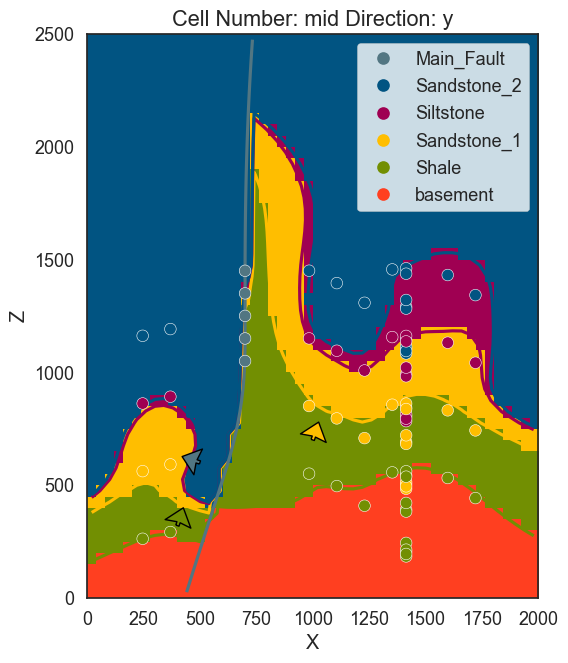

In [31]:
gp.plot_2d(geo_model, series_n=1, show_block=True, show_lith=False)
plt.show()

### Marching cubes and vtk visualization

In addition to 2D sections we can extract surfaces to visualize in 3D
renderers. Surfaces can be visualized as 3D triangle complexes in VTK
(see function plot\_surfaces\_3D below). To create these triangles, we
need to extract respective vertices and simplices from the potential
fields of lithologies and faults. This process is automatized in GemPy
with the function ``get_surface``\ .




In [33]:
ver, sim = gp.get_surfaces(geo_model)
gpv = gp.plot_3d(geo_model, image=False, plotter_type='basic')

Using the rescaled interpolation data, we can also run our 3D VTK
visualization in an interactive mode which allows us to alter and update
our model in real time. Similarly to the interactive 3D visualization of
our input data, the changes are permanently saved (in the
``InterpolationInput.dataframe`` object). Additionally, the resulting changes
in the geological models are re-computed in real time.




### Adding topography



In [33]:
geo_model.set_topography(d_z=(350, 750))

Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  20.        ,   30.        ,   25.        ],
       [  20.        ,   30.        ,   75.        ],
       [  20.        ,   30.        ,  125.        ],
       ...,
       [2000.        , 2877.55102041,  423.48951452],
       [2000.        , 2938.7755102 ,  430.25455308],
       [2000.        , 3000.        ,  431.07163663]])

d:\anaconda3\envs\gempy-env\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


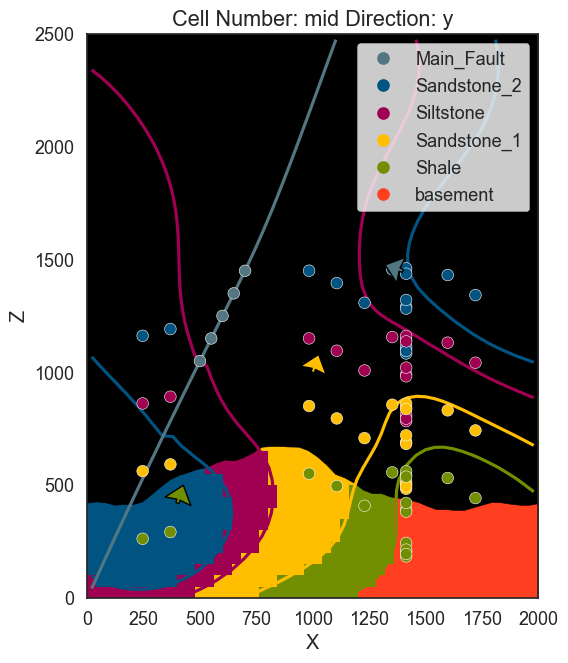

In [34]:
gp.compute_model(geo_model)
gp.plot_2d(geo_model, show_topography=True)
plt.show()


# sphinx_gallery_thumbnail_number = 9
gpv = gp.plot_3d(geo_model, plotter_type='basic', show_topography=True, show_surfaces=True,
                 show_lith=True,
                 image=False)

### Compute at a given location

This is done by modifying the grid to a custom grid and recomputing.
Notice that the results are given as *grid + surfaces\_points\_ref +
surface\_points\_rest locations*




In [36]:
x_i = np.array([[3, 5, 7]])
sol = gp.compute_model(geo_model, at=x_i)

Active grids: []


Therefore if we just want the value at **x\_i**:



In [37]:
sol.custom

This return the id, and the scalar field values for each series



### Save the model




GemPy uses Python [pickle] for fast storing temporary objects
(https://docs.python.org/3/library/pickle.html). However, module version
consistency is required. For loading a pickle into GemPy, you have to
make sure that you are using the same version of pickle and dependent
modules (e.g.: ``Pandas``, ``NumPy``) as were used when the data was
originally stored.

For long term-safer storage we can export the ``pandas.DataFrames`` to
csv by using:




In [38]:
gp.save_model(geo_model)

True